In [187]:
import sys
sys.path.append('..')

import os
import cv2
import json
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

from src.utils.config import RENDER_FOLDER_PATH

HEATMAP_WIDTH = 100
HEATMAP_HEIGHT = 100

In [196]:
def show_led_locations(render_folder_name, frame_number):
    render_folder_path = os.path.join(RENDER_FOLDER_PATH, render_folder_name)
    if not os.path.isdir(render_folder_path):
        print(f"Render folder {render_folder_path} not found.")
        return
    frame_file_path = os.path.join(render_folder_path, f"bg", f"{frame_number}.png")
    if not os.path.isfile(frame_file_path):
        print(f"Frame file {frame_file_path} not found.")
        return
    data_file_path = os.path.join(render_folder_path, f"data.json")
    if not os.path.isfile(data_file_path):
        print(f"Data file {data_file_path} not found.")
        return
    
    frame_image = cv2.imread(frame_file_path)
    frame_image_width = frame_image.shape[1]
    frame_image_height = frame_image.shape[0]
    frame_image_occlusion = frame_image.copy()
    frame_image_relative_orientation = frame_image.copy()
    patches_occlusion = []
    patches_relative_orientation = []
    with open(data_file_path, 'r') as f:
        data = json.load(f)[str(frame_number)]
        for _, led_data in data.items():
            u = int(led_data["u"] * frame_image_width)
            v = int((1 - led_data["v"]) * frame_image_height)
            is_occluded = bool(led_data["is_occluded"])
            led_relative_orientation = (led_data["led_relative_orientation"] + 1) / 2
            
            if u < 0 or u >= frame_image_width or v < 0 or v >= frame_image_height:
                continue
            
            color_occlusion = (1, 0, 0, 0.3) if is_occluded else (0, 1, 0, 0.3)  # RGBA color with alpha
            color_relative_orientation = (0, led_relative_orientation, 1 - led_relative_orientation, 0.3)  # RGBA color with alpha
            
            # Create circles
            circle_occlusion = Circle((u, v), radius=2, color=color_occlusion)
            circle_relative_orientation = Circle((u, v), radius=2, color=color_relative_orientation)
            
            # Append to patch lists
            patches_occlusion.append(circle_occlusion)
            patches_relative_orientation.append(circle_relative_orientation)

    # Create PatchCollections
    pc_occlusion = PatchCollection(patches_occlusion, match_original=True)
    pc_relative_orientation = PatchCollection(patches_relative_orientation, match_original=True)

    # Plotting
    plt.figure(figsize=(48, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(frame_image_occlusion, cv2.COLOR_BGR2RGB))
    plt.title("Occlusion")
    plt.axis('off')
    plt.gca().add_collection(pc_occlusion)

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(frame_image_relative_orientation, cv2.COLOR_BGR2RGB))
    plt.title("Relative Orientation")
    plt.axis('off')
    plt.gca().add_collection(pc_relative_orientation)

    plt.show()

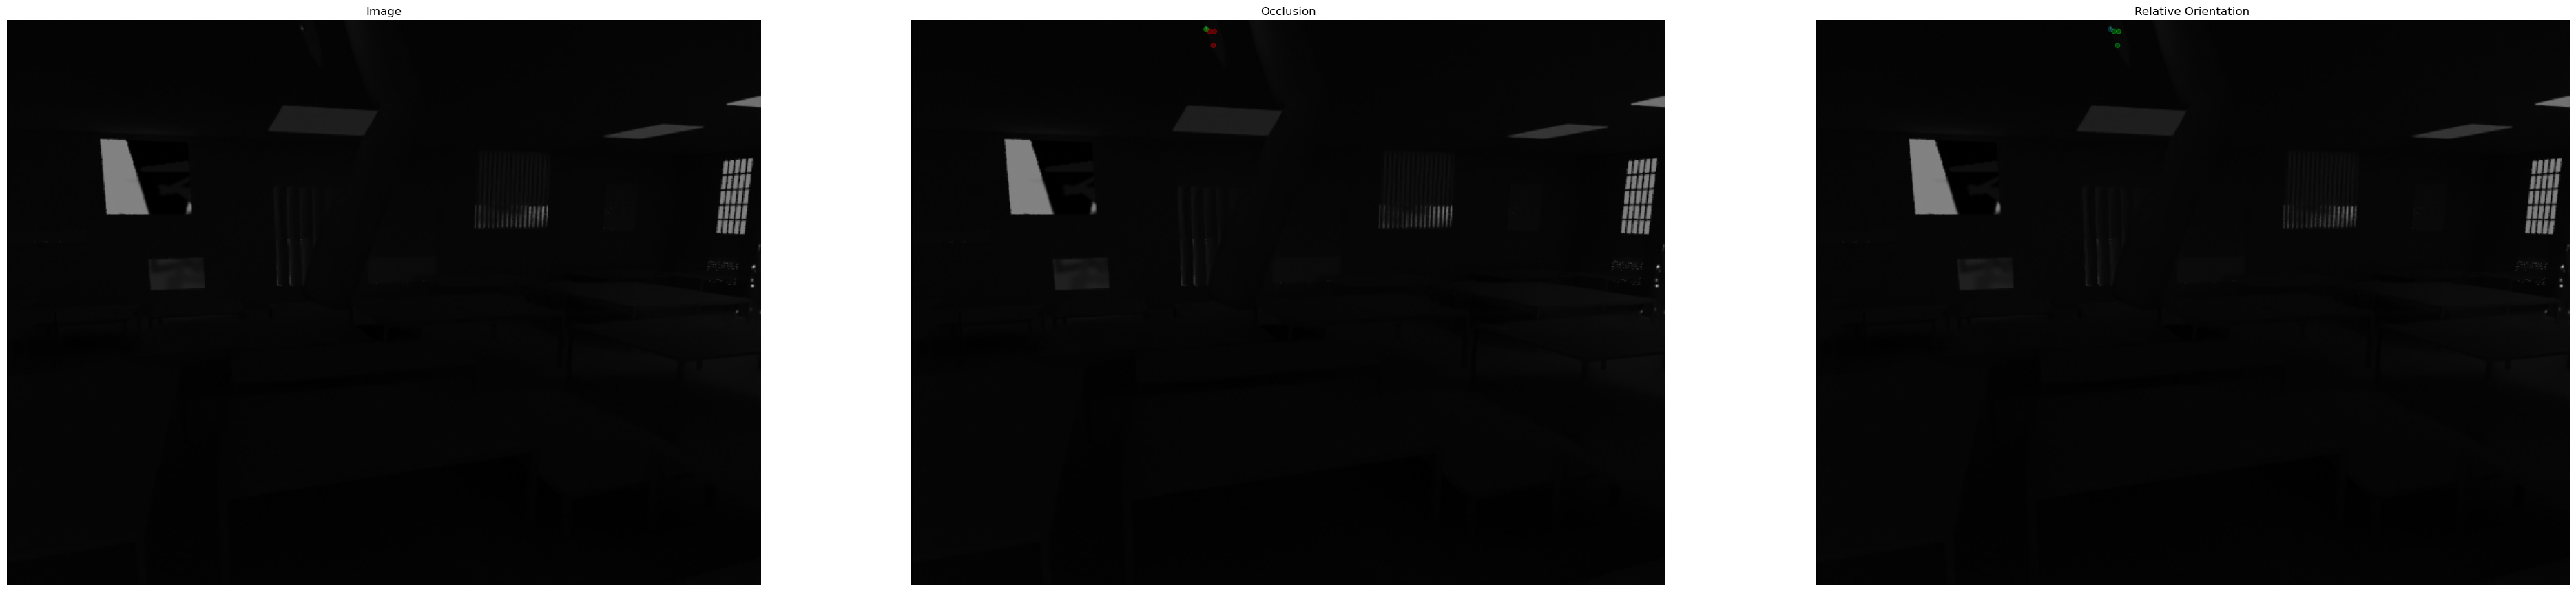

In [204]:
show_led_locations("8", 1)

100%|██████████| 13/13 [00:00<00:00, 51.18it/s]


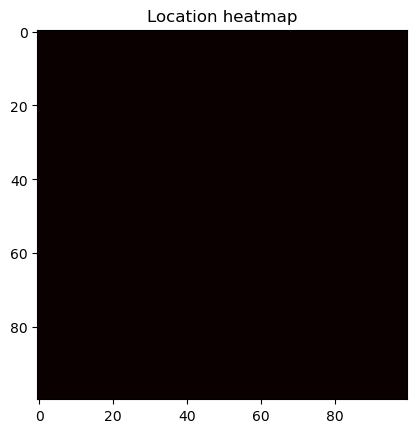

In [50]:
location_heatmap = np.zeros((HEATMAP_WIDTH, HEATMAP_HEIGHT))
render_folder_paths = os.listdir(RENDER_FOLDER_PATH)
for render_folder_path in tqdm(render_folder_paths):
    data_file_path = os.path.join(RENDER_FOLDER_PATH, render_folder_path, "data.json")
    if not os.path.exists(data_file_path):
        print(f"Data file not found for render folder {render_folder_path}.")
        continue
    
    with open(data_file_path, "r") as f:
        data = json.load(f)["0"]
        for _, led_data in data.items():
            u = int(led_data["u"] * HEATMAP_WIDTH)
            v = int(led_data["v"] * HEATMAP_HEIGHT)
            
            if u < 0 or u >= HEATMAP_WIDTH or v < 0 or v >= HEATMAP_HEIGHT:
                continue
            
            location_heatmap[u, v] += 1
            
plt.figure()
plt.title("Location heatmap")
plt.imshow(location_heatmap, cmap="hot", interpolation="nearest")
plt.show()  
            